In [13]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps

import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing, equ2gal

from qubic.lib.MapMaking.Qmaps import InputMaps

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockColumnOperator, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline 

In [14]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [15]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

300


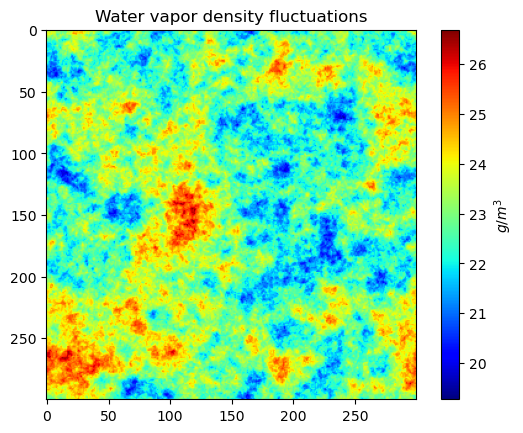

In [16]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
plt.imshow(wv_fluctuations, cmap='jet')
plt.title('Water vapor density fluctuations')
plt.colorbar(label=r'$g/m^{3}$')

In [17]:
atm.frequencies

array([134.05713053, 139.79146751, 145.7710926 , 152.00649808,
       158.50862505, 165.28888259, 196.61712478, 205.02748568,
       213.79760248, 222.94286386, 232.47931674, 242.42369446])

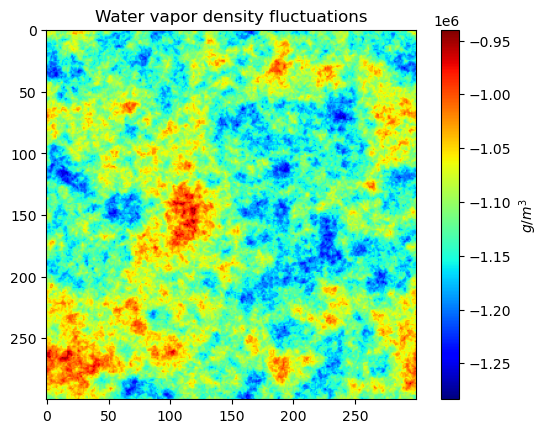

In [18]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], wv_fluctuations.shape[1], 3))
temp_fluctuations[..., 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[..., 0] -= np.mean(temp_fluctuations[:, 0])

plt.imshow(temp_fluctuations[..., 0], cmap='jet')
plt.title('Water vapor density fluctuations')
plt.colorbar(label=r'$g/m^{3}$')

316.44761928968586 -58.75808063333319


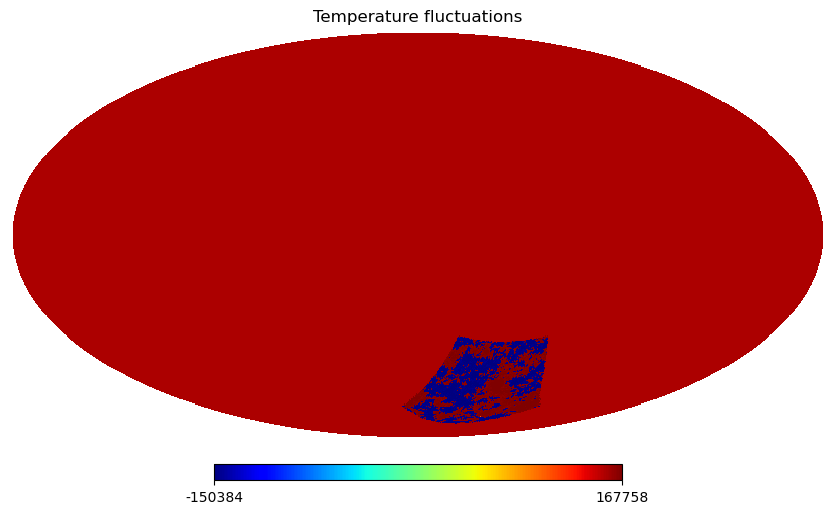

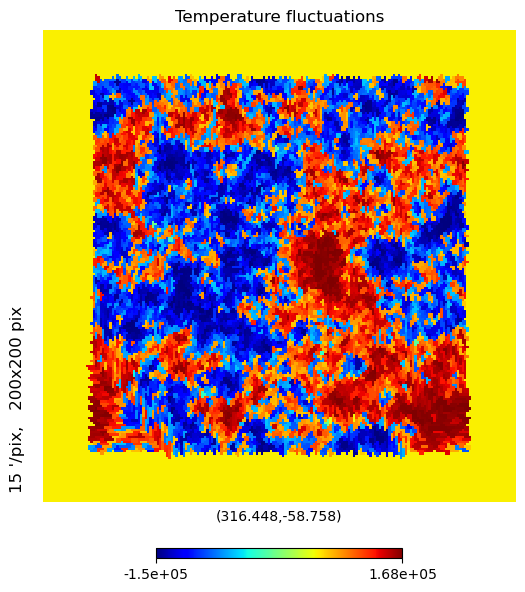

In [19]:
healpy_temp_fluctuations = np.zeros((hp.nside2npix(params['nside']), 3))
healpy_temp_fluctuations[..., 0] = atm.get_healpy_atm_maps_2d(atm.get_temp_maps(wv_fluctuations))[0]
index = np.where(healpy_temp_fluctuations!=0)[0]
healpy_temp_fluctuations[index, 0] -= np.mean(healpy_temp_fluctuations[index, 0])
min = np.min(healpy_temp_fluctuations[index, 0])
max = np.max(healpy_temp_fluctuations[index, 0])

hp.mollview(healpy_temp_fluctuations[..., 0], min=min, max=max, norm='hist', cmap='jet', title='Temperature fluctuations')
hp.gnomview(healpy_temp_fluctuations[..., 0], min=min, max=max, rot=equ2gal(0, -57), norm='hist', reso=15, cmap='jet', title='Temperature fluctuations')

In [20]:
print('Angular speed', qubic_dict['angspeed'])
print('Delta azimtuh', qubic_dict['delta_az'])
print('Sweeps per elevation', qubic_dict['nsweeps_per_elevation'])
print('latitude', qubic_dict['latitude'])
print('longitude', qubic_dict['longitude'])
print('Fix_azimuth', qubic_dict['fix_azimuth'])
print('period', qubic_dict['period'])
print('duration', qubic_dict['duration'])

Angular speed 0.4
Delta azimtuh 20
Sweeps per elevation 1
latitude -24.183333333333334
longitude -66.46666666666667
Fix_azimuth {'apply': False, 'az': 50, 'el': 50, 'el_step': 1, 'fix_hwp': True, 'fix_pitch': True}
period 1
duration 20


In [21]:
### Random pointing
qubic_dict['random_pointing'] = False

### Sweepingpointing
qubic_dict['sweeping_pointing'] = True
qubic_dict['fix_azimuth']['apply'] = True 
qubic_dict['duration'] = 1

### Repeat pointing
qubic_dict['repeat_pointing'] = False

q_sampling = get_pointing(qubic_dict)
print(q_sampling)

QubicSampling((3600,), 
    index=[   0    1    2 ... 3597 3598 3599],
    angle_hwp=[15. 15. 15. ... 15. 15. 15.],
    azimuth=[40.  40.4 40.8 ... 41.2 40.8 40.4],
    elevation=[32. 32. 32. ... 67. 67. 67.],
    equatorial=[[69.6513037  22.05793677]
 [69.93806474 21.84258997]
 [70.223112,
    galactic=[[176.82127448 -16.29072576]
 [177.16997832 -16.21967022]
 [177.5,
    masked=False,
    pitch=[0. 0. 0. ... 0. 0. 0.])


Text(0, 0.5, 'Elevation (degrees)')

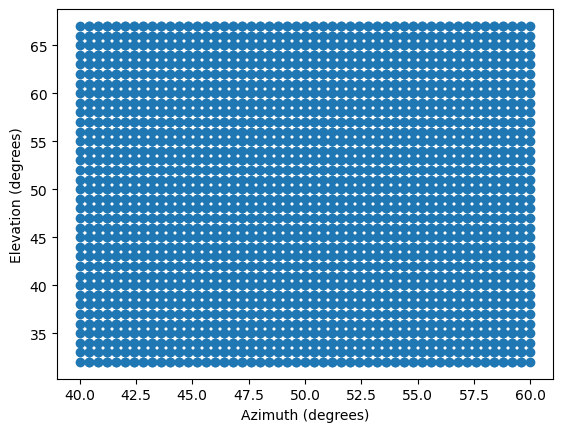

In [22]:
plt.plot(q_sampling.azimuth, q_sampling.elevation, 'o')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Elevation (degrees)')

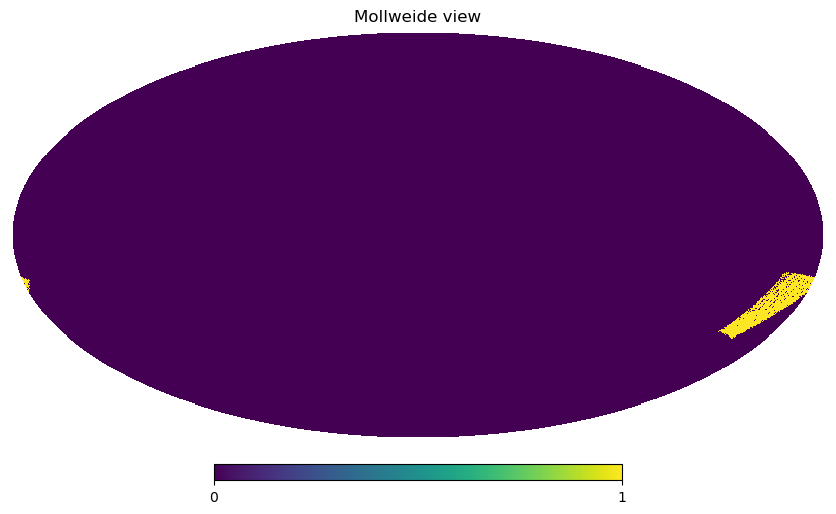

In [23]:
from pysimulators.interfaces.healpy import Spherical2HealpixOperator
test = np.zeros(hp.nside2npix(params['nside']))
index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians([q_sampling.galactic])), dtype='int')
test[index] = 1
hp.mollview(test)

In [24]:
q_instrument = QubicInstrument(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

In [25]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info apcnb2325: Allocating (3571200,9) elements = 490.4296875 MiB in FSRRotation3dMatrix.__init__.


In [26]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(healpy_temp_fluctuations).ravel()

Info apcnb2325: Allocating (3571200,9) elements = 490.4296875 MiB in FSRRotation3dMatrix.__init__.


In [27]:
H = R_qubic(H_qubic)
invN = invN_qubic
d = d_qubic

In [28]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = healpy_temp_fluctuations*0
true_maps = healpy_temp_fluctuations

In [29]:
stacked_dptdp_inv = np.zeros((1,12*params['nside']**2))

D = H.operands[2]
P = H.operands[-1]
sh = P.matrix.data.index.shape
no_det = 992
point_per_det = int(sh[0] / no_det)
mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
for det, (start, end) in enumerate(sample_ranges):
    indices = P.matrix.data.index[start:end, :]  
    weights = P.matrix.data.r11[start:end, :]
    flat_indices = indices.ravel()
    flat_weights = weights.ravel()

    mapPitPi = np.zeros(12 * params['nside']**2)
    np.add.at(mapPitPi, flat_indices, flat_weights**2)

    mapPtP_perdet_seq[det, :] = mapPitPi
D_elements = D.data
D_sq = D_elements**2
mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
dptdp = mapPtP_seq_scaled.sum(axis = 0)
dptdp_inv = 1 / dptdp
dptdp_inv[np.isinf(dptdp_inv)] = 0.
stacked_dptdp_inv[0] = dptdp_inv
M = BlockDiagonalOperator( \
            [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
            new_axisin=0)

In [30]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-15,
    maxiter=200,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

Text(0, 0.5, 'Convergence')

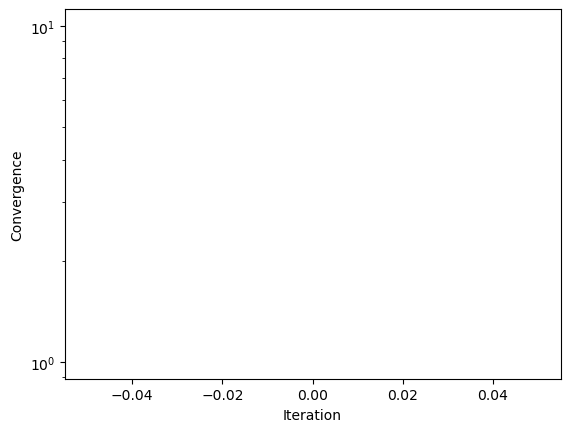

In [31]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

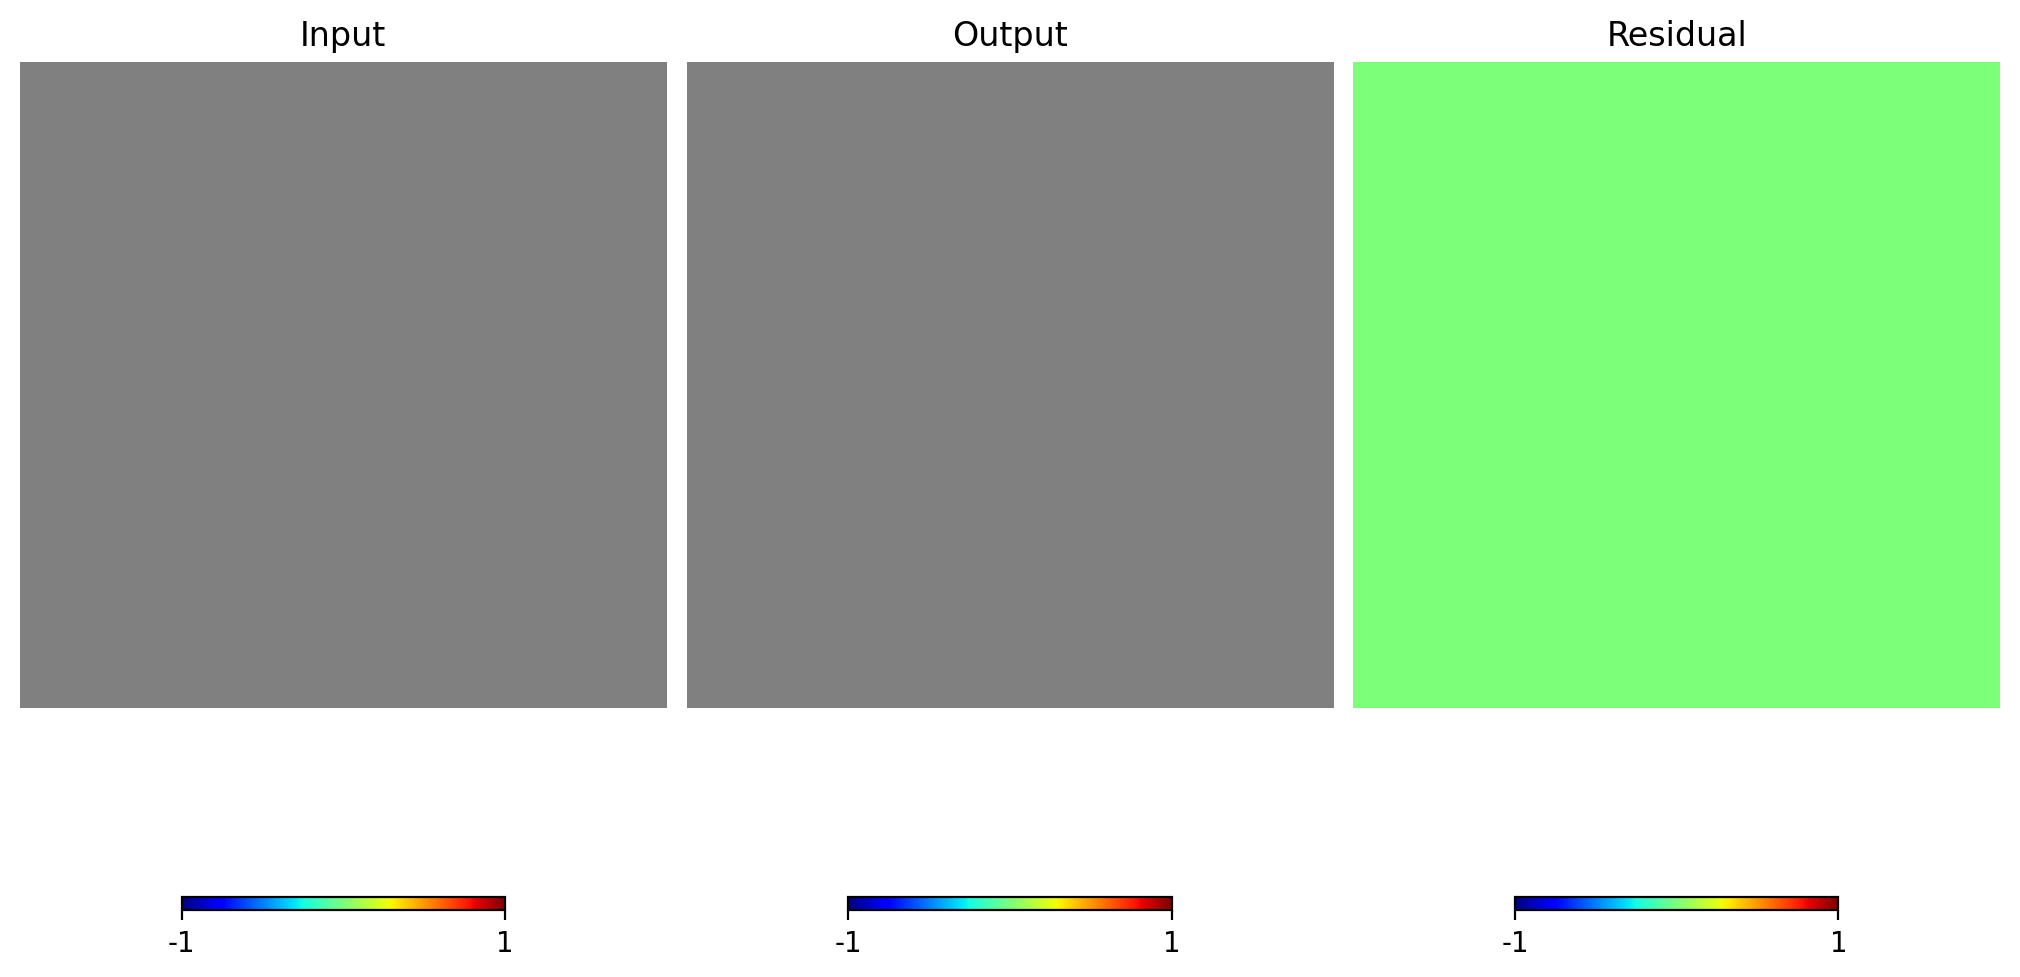

In [32]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

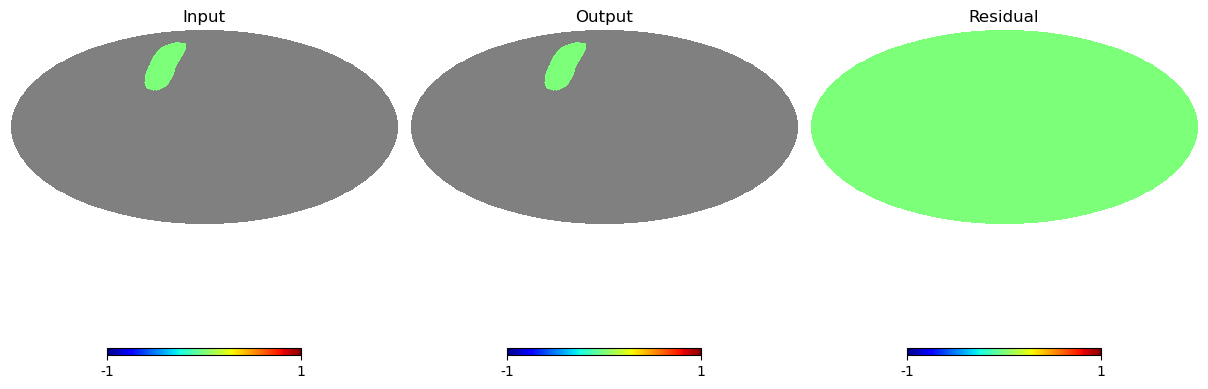

In [33]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

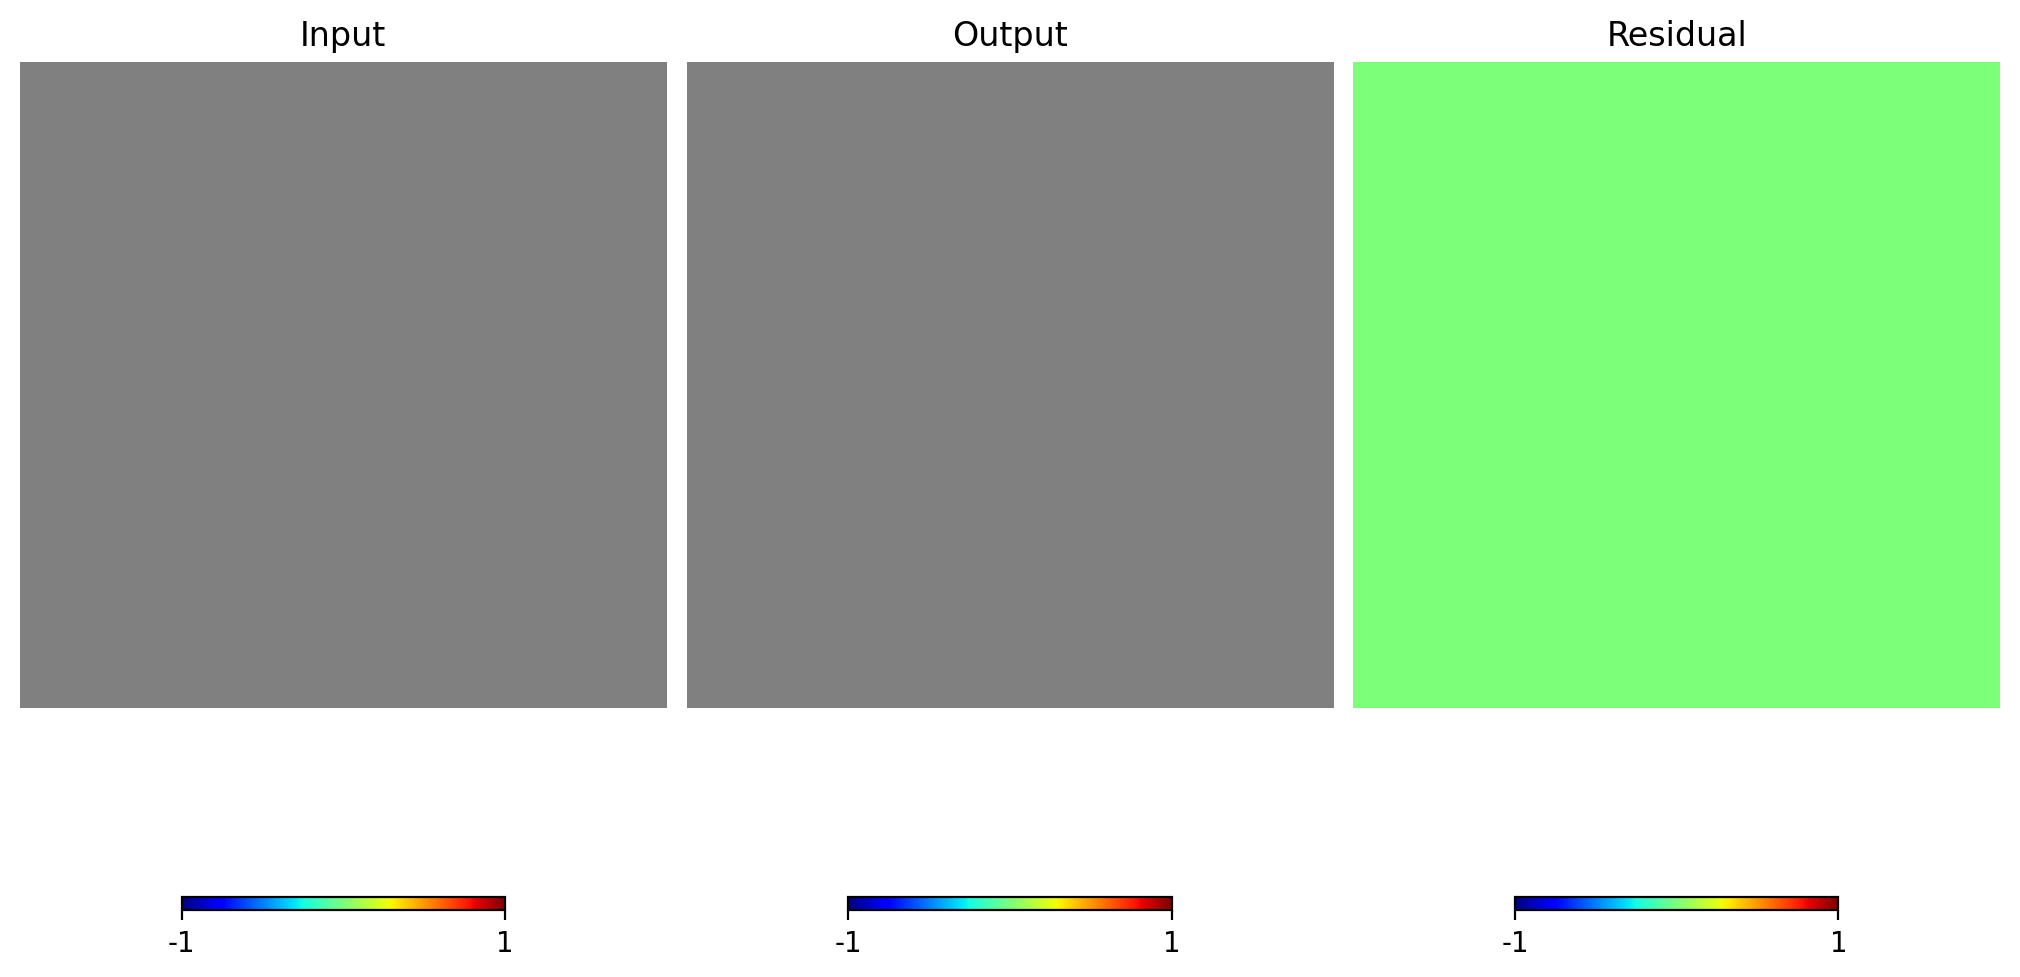

In [34]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3